# Beam Ionization

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
import matplotlib.pyplot as plt
import beam.calc.electron as ecalc
from scipy.integrate import simps
from scipy.constants import physical_constants as consts
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from ionization import adk

sys.path.insert(0, "../../khuntstone/Field_Ionization")
sys.path.insert(0, "../../khuntstone")
import eBeam_v02 as eb
import plotty as pl

plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/E301/E301_1/'
lam = 0.796
eps0 = consts['electric constant'][0]

This notebook looks at the effect of lengthening the beam on the beam ionization. This is used for PIC simulations to model the ionization correctly while using longer beams.

In [2]:
def calc_Er(beamParams, r, xi):
    Er = np.zeros((len(r), len(xi)))
    ppK =  eb.peak_charge_dens(beamParams)
    sigma_r = beamParams['sigma_r']
    sigma_z = beamParams['sigma_z']
    sel = r != 0
    r = r[sel, None]
    Er[sel, :] = (ppK * sigma_r**2 / (eps0 * r)) * \
                (1 - np.exp(-r**2/(2*sigma_r**2))) * \
                np.exp(-(xi)**2 / (2 * sigma_z**2))
    Er[:, :] = Er[:, :] / 1e9
    return Er

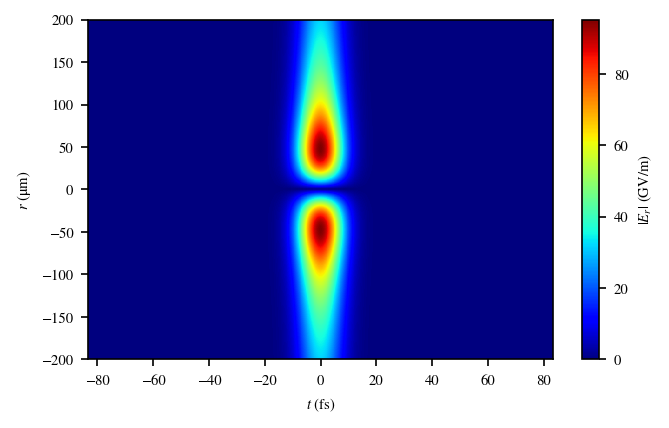

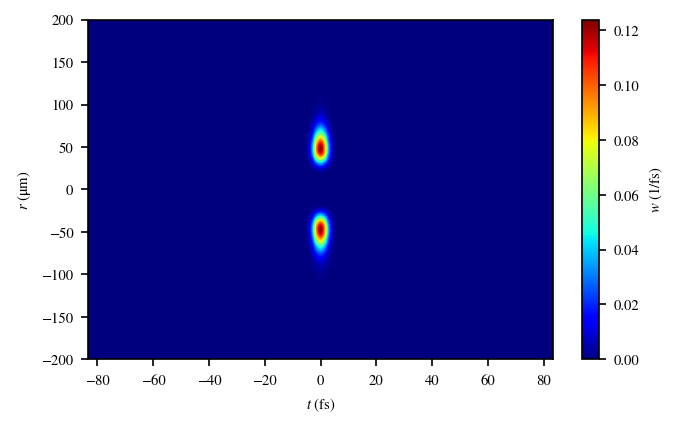

In [3]:
# Multiply the transverse domain to zoom in on the beam
beamParams = {'sigma_z' : 1.7e-6,
              'sigma_r': 30e-6,
              'charge' : 1.5*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))

ext = [min(t), max(t), min(r)*1e6, max(r)*1e6]
fig = plt.figure(figsize = (5,3), dpi = 150)
ax = fig.gca()
img = ax.imshow(np.flipud(abs(Er)), cmap = 'jet',aspect = 'auto', \
    extent = ext)
cbar = plt.colorbar(mappable = img, ax = ax)
cbar.set_label('$|E_r|$ (GV/m)')
ax.set_xlabel(r'$t$ (fs)');
ax.set_ylabel(r'$r$ ($\mathrm{\mu m}$)');
plt.show()

fig = plt.figure(figsize = (5,3), dpi = 150)
ax = fig.gca()
img = ax.imshow(np.flipud(rate_x_He), cmap = 'jet',aspect = 'auto', \
    extent = ext)
cbar = plt.colorbar(mappable = img, ax = ax)
cbar.set_label('$w$ (1/fs)')
ax.set_xlabel(r'$t$ (fs)');
ax.set_ylabel(r'$r$ ($\mathrm{\mu m}$)');
plt.show()

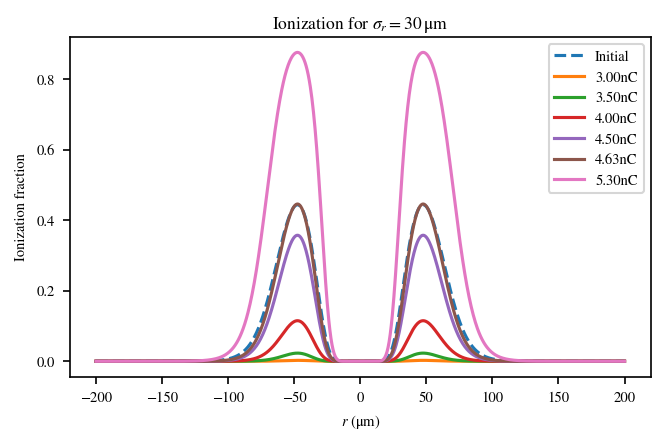

In [4]:
# Multiply the transverse domain to zoom in on the beam
charge = np.array([3.0, 3.5, 4.0, 4.5, 4.63, 5.3])
sigma_r = 30e-6
N = len(charge)
# Calculate properties for the initial beam
beamParams = {'sigma_z' : 1.7e-6,
              'sigma_r': sigma_r,
              'charge' : 1.5*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))
# Calculate the ionization fraction for different beam charges
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(r*1e6, ne0, '--', label='Initial')
for i in range(N):
    beamParams = {'sigma_z' : 6e-6,
                  'sigma_r': sigma_r,
                  'charge' : charge[i]*1e-9}
    Er = calc_Er(beamParams, r, xi)
    rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
    ne = 1-np.exp(-simps(rate_x_He, t))
    plt.plot(r*1e6, ne, label='%0.2fnC'%(charge[i]))
plt.legend()
plt.title('Ionization for $\sigma_r=30\,\mathrm{\mu m}$')
plt.xlabel(r'$r$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Ionization fraction')
plt.show()

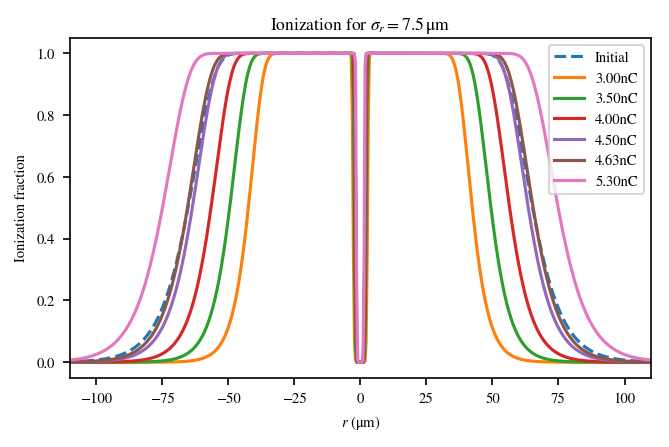

In [5]:
# Multiply the transverse domain to zoom in on the beam
charge = np.array([3.0, 3.5, 4.0, 4.5, 4.63, 5.3])
sigma_r = 7.5e-6
N = len(charge)
# Calculate properties for the initial beam
beamParams = {'sigma_z' : 1.7e-6,
              'sigma_r': sigma_r,
              'charge' : 1.5*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))
# Calculate the ionization fraction for different beam charges
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(r*1e6, ne0, '--', label='Initial')
for i in range(N):
    beamParams = {'sigma_z' : 6e-6,
                  'sigma_r': sigma_r,
                  'charge' : charge[i]*1e-9}
    Er = calc_Er(beamParams, r, xi)
    rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
    ne = 1-np.exp(-simps(rate_x_He, t))
    plt.plot(r*1e6, ne, label='%0.2fnC'%(charge[i]))
plt.legend()
plt.title('Ionization for $\sigma_r=7.5\,\mathrm{\mu m}$')
plt.xlabel(r'$r$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Ionization fraction')
plt.xlim(-110, 110)
plt.show()

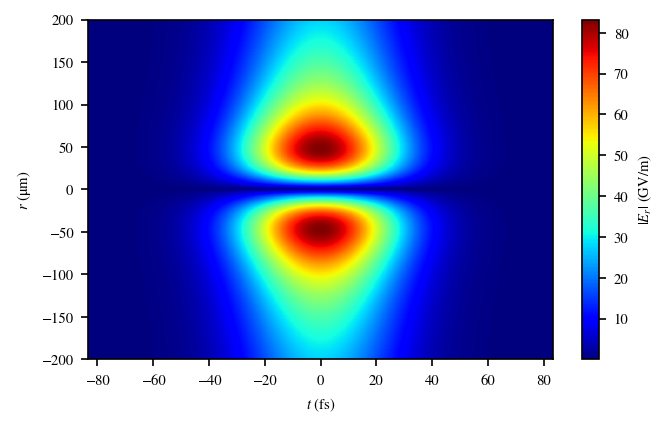

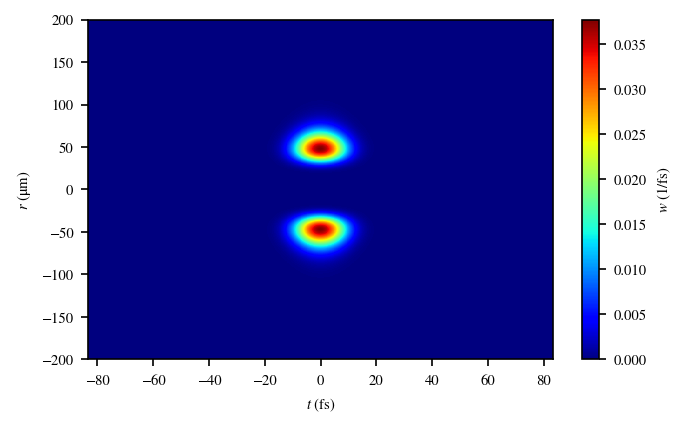

In [6]:
# Multiply the transverse domain to zoom in on the beam
beamParams = {'sigma_z' : 6e-6,
              'sigma_r': 30e-6,
              'charge' : 4.63*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))

ext = [min(t), max(t), min(r)*1e6, max(r)*1e6]
fig = plt.figure(figsize = (5,3), dpi = 150)
ax = fig.gca()
img = ax.imshow(np.flipud(abs(Er)), cmap = 'jet',aspect = 'auto', \
    extent = ext)
cbar = plt.colorbar(mappable = img, ax = ax)
cbar.set_label('$|E_r|$ (GV/m)')
ax.set_xlabel(r'$t$ (fs)');
ax.set_ylabel(r'$r$ ($\mathrm{\mu m}$)');
plt.show()

fig = plt.figure(figsize = (5,3), dpi = 150)
ax = fig.gca()
img = ax.imshow(np.flipud(rate_x_He), cmap = 'jet',aspect = 'auto', \
    extent = ext)
cbar = plt.colorbar(mappable = img, ax = ax)
cbar.set_label('$w$ (1/fs)')
ax.set_xlabel(r'$t$ (fs)');
ax.set_ylabel(r'$r$ ($\mathrm{\mu m}$)');
plt.show()

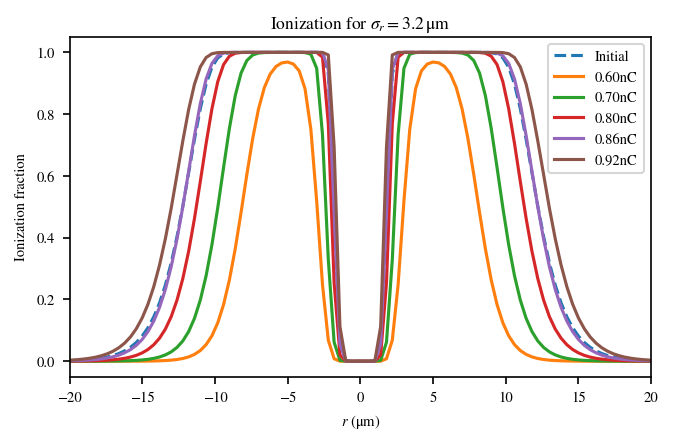

In [7]:
# Multiply the transverse domain to zoom in on the beam
charge = np.array([0.6, 0.7, 0.8, 0.865, 0.92])
sigma_r = 3.2e-6
N = len(charge)
# Calculate properties for the initial beam
beamParams = {'sigma_z' : 3.25e-6,
              'sigma_r': sigma_r,
              'charge' : 0.5*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))
# Calculate the ionization fraction for different beam charges
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(r*1e6, ne0, '--', label='Initial')
for i in range(N):
    beamParams = {'sigma_z' : 6e-6,
                  'sigma_r': sigma_r,
                  'charge' : charge[i]*1e-9}
    Er = calc_Er(beamParams, r, xi)
    rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
    ne = 1-np.exp(-simps(rate_x_He, t))
    plt.plot(r*1e6, ne, label='%0.2fnC'%(charge[i]))
plt.legend()
plt.title('Ionization for $\sigma_r=3.2\,\mathrm{\mu m}$')
plt.xlabel(r'$r$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Ionization fraction')
plt.xlim(-20, 20)
plt.show()

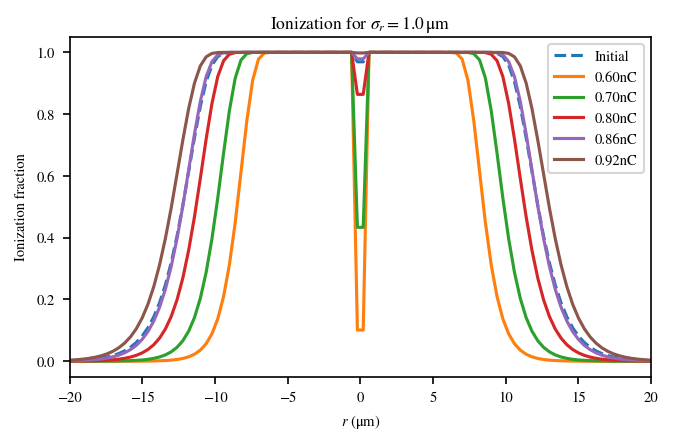

In [8]:
# Multiply the transverse domain to zoom in on the beam
charge = np.array([0.6, 0.7, 0.8, 0.865, 0.92])
sigma_r = 1.0e-6
N = len(charge)
# Calculate properties for the initial beam
beamParams = {'sigma_z' : 3.25e-6,
              'sigma_r': sigma_r,
              'charge' : 0.5*1e-9}
atom = ionization.He
r = np.linspace(-200e-6, 200e-6, 1000)
xi = np.linspace(-25e-6, 25e-6, 1000)
t = xi*1e15/consts['speed of light in vacuum'][0]
Er = calc_Er(beamParams, r, xi)
rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
ne0 = 1-np.exp(-simps(rate_x_He, t))
# Calculate the ionization fraction for different beam charges
fig = plt.figure(figsize=(5, 3), dpi=150)
plt.plot(r*1e6, ne0, '--', label='Initial')
for i in range(N):
    beamParams = {'sigma_z' : 6e-6,
                  'sigma_r': sigma_r,
                  'charge' : charge[i]*1e-9}
    Er = calc_Er(beamParams, r, xi)
    rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
    ne = 1-np.exp(-simps(rate_x_He, t))
    plt.plot(r*1e6, ne, label='%0.2fnC'%(charge[i]))
plt.legend()
plt.title('Ionization for $\sigma_r=1.0\,\mathrm{\mu m}$')
plt.xlabel(r'$r$ ($\mathrm{\mu m}$)')
plt.ylabel(r'Ionization fraction')
plt.xlim(-20, 20)
plt.show()